In [3]:
from plotly import __version__
from plotly.offline import download_plotlyjs, init_notebook_mode, iplot
from plotly.offline import plot
from plotly.graph_objs import Scatter



import plotly as py
import pandas as pd
from plotly import session, tools, utils
import uuid
import json
from plotly import tools
import plotly.graph_objs as go

init_notebook_mode() 

def get_plotlyjs():
    path = os.path.join('plotly.min.js')
    plotlyjs = resource_string('plotly', path).decode('utf-8')
    return plotlyjs


def new_iplot(figure_or_data, show_link=True, link_text='Export to plot.ly',
          validate=True):

    figure = tools.return_figure_from_figure_or_data(figure_or_data, validate)

    width = figure.get('layout', {}).get('width', '100%')
    height = figure.get('layout', {}).get('height', 525)
    try:
        float(width)
    except (ValueError, TypeError):
        pass
    else:
        width = str(width) + 'px'

    try:
        float(width)
    except (ValueError, TypeError):
        pass
    else:
        width = str(width) + 'px'

    plotdivid = uuid.uuid4()
    jdata = json.dumps(figure.get('data', []), cls=utils.PlotlyJSONEncoder)
    jlayout = json.dumps(figure.get('layout', {}), cls=utils.PlotlyJSONEncoder)

    config = {}
    config['showLink'] = show_link
    config['linkText'] = link_text
    jconfig = json.dumps(config)

    plotly_platform_url = session.get_session_config().get('plotly_domain',
                                                           'https://plot.ly')
    if (plotly_platform_url != 'https://plot.ly' and
            link_text == 'Export to plot.ly'):

        link_domain = plotly_platform_url\
            .replace('https://', '')\
            .replace('http://', '')
        link_text = link_text.replace('plot.ly', link_domain)


    script = '\n'.join([
        'Plotly.plot("{id}", {data}, {layout}, {config}).then(function() {{',
        '    $(".{id}.loading").remove();',
        '}})'
    ]).format(id=plotdivid,
              data=jdata,
              layout=jlayout,
              config=jconfig)

    html="""<div class="{id} loading" style="color: rgb(50,50,50);">
                 Drawing...</div>
                 <div id="{id}" style="height: {height}; width: {width};" 
                 class="plotly-graph-div">
                 </div>
                 <script type="text/javascript">
                 {script}
                 </script>
                 """.format(id=plotdivid, script=script,
                           height=height, width=width)

    return html

import LHCclass
import madxmodule
import pandas as pd
import numpy as np
import matplotlib
from matplotlib import pyplot as plt
import csv
import glob
import datetime
import collections
import time
import subprocess
import os
from scipy import optimize as opt
from scipy import constants as const
from StringIO import StringIO
from matplotlib import rc,rcParams
from matplotlib.patches import Rectangle
import itertools

# simdata
from pandas.tools.plotting import autocorrelation_plot
from pandas.tools.plotting import lag_plot
from pandas.tools.plotting import scatter_matrix

s1 = time.time()

# loading measured data to compare with madx
# ------------------------------------------
fill4707 = LHCclass.LHCfill(4707,'/afs/cern.ch/work/t/tomerten/HI2015')
fill4696 = LHCclass.LHCfill(4696,'/afs/cern.ch/work/t/tomerten/HI2015')


# setting bump amplitude
# ----------------------
bumpamplist  = [-0.0005,0.000,0.001,0.002,0.003,0.004,0.005] # be careful for B1 signs needs to be opposite ->Beam4
npart        = 50

basefilelist =[['lhcb4-twiss-bfpp-'+ i + '.tfs'] for i in ['m0p5','0p0','1p0','2p0','3p0','4p0','5p0']] 

errorstringlist = ['']
corrlist        = np.array(['MCBCH.7L5.B2', 'MCBCH.9L5.B2', 'MCBH.13L5.B2'])


# twiss file list
# ---------------
basetwissfilelist = [[madxmodule.Twiss('lhcb2',basefilelist[j][i],targetxc=bumpamplist[j],IPcycle='IP5',
                                       targetel="MQ.11L5.B2",
                                       correctorlist=corrlist,errorseq=errorstringlist[i],
                                       twisscols=madxmodule.MADtwissColumns["LHCTwiss"],
                                       beam=[madxmodule.MADX_Beam(1,seq='LHCB1',energy=82.*6370.),
                                             madxmodule.MADX_Beam(2,seq='LHCB2',energy=82.*6370.)]) 
                      for i in range(len(basefilelist[j]))] for j in range(len(basefilelist))]


# initial parameters for BFPP
# ---------------------------
initialdictlist = [[madxmodule.get_initial(fn,madxmodule.dpPb(0,-1),location='IP5') 
                    for fn in basetwissfilelist[i]] for i in range(len(basetwissfilelist))]  


flist = [fn[0] for fn in [basetwissfilelist[i] for i in range(len(basetwissfilelist))]]

basedflist = [pd.read_csv(fn,
                skiprows=range(47),
                         delim_whitespace=True,
                         names =madxmodule.MADtwissColumns["LHCTwiss"])
              for fn in flist]


s2 = time.time()

In [4]:
flist = [fn[0] for fn in [basetwissfilelist[i] for i in range(len(basetwissfilelist))]]

basedflist = [pd.read_csv(fn,
                skiprows=range(47),
                         delim_whitespace=True,
                         names =madxmodule.MADtwissColumns["LHCTwiss"])
              for fn in flist]

In [5]:
fill4707.summarydf

,Description,Value,StartTime(UTC_TIME),EndTime(UTC_TIME)
0,Fill Number,4707,2015-12-08 15:48:28.101,2015-12-08 20:19:42.575
1,Beam Mode,SETUP,2015-12-08 16:22:39.039,2015-12-08 17:41:57.701
2,Beam Mode,INJPROT,2015-12-08 17:41:57.702,2015-12-08 17:59:39.258
3,Beam Mode,INJPHYS,2015-12-08 17:59:39.259,2015-12-08 18:51:30.275
4,Beam Mode,PRERAMP,2015-12-08 18:51:30.276,2015-12-08 18:54:43.555
5,Beam Mode,RAMP,2015-12-08 18:54:43.556,2015-12-08 19:15:11.137
6,Beam Mode,FLATTOP,2015-12-08 19:15:11.138,2015-12-08 19:19:04.762
7,Beam Mode,SQUEEZE,2015-12-08 19:19:04.763,2015-12-08 19:24:07.668
8,Beam Mode,SQUEEZE,2015-12-08 19:24:07.669,2015-12-08 19:37:07.426
9,Beam Mode,ADJUST,2015-12-08 19:37:07.427,2015-12-08 20:11:52.394


# Plotting setup

In [6]:
globals()['rcParams']['font.size']=16.0
globals()['rcParams']['xtick.major.size']=12.0
globals()['rcParams']['ytick.major.size']=12.0
globals()['rcParams']['axes.labelsize']=12.0
globals()['rcParams']['xtick.labelsize']=12.0
globals()['rcParams']['ytick.labelsize']=12.0

In [ ]:
df1 = basedflist[1].set_index('S')[['X','Y','NAME']]

In [7]:
def plotbpm(LHCfill,tfslhcb1,tfslhcb2,ipnr=5,nn=50,step=20):
    bpmltest,namesl,tfsbpml,bpmrtest,namesr,tfsbpmr = LHCfill.transformbpmdata(
                                                    tfslhcb1,
                                                    tfslhcb2,
                                                    ipnr=ipnr
                                                   )
    from IPython.html.widgets import FloatProgress
    from IPython.display import display
    f = FloatProgress(min=0,max=2*nn/float(step))
    display(f)

    error = False

    fig = plt.figure(figsize=(18,20))
    ax  = fig.add_subplot(211)

    s1   = np.array([float(tfsbpml[tfsbpml['NAME']==n]['S'].values[0]) for n in namesl])
    max1 = len(bpmltest)


    for i in range(0,len(bpmltest.tail(nn)),step):
        try:
            data = np.array([bpmltest[n][max1-nn+i] for n in namesl])
            plt.scatter(s1,data)
            plt.plot(s1,data)
            f.value = i
        except:
            print 'nn out of range'
            error = True
            break


    plt.plot((0,500),(500,500),'k-')
    plt.plot((0,500),(-500,-500),'k-')
    plt.plot((0,500),(-3000,-3000),'k-')
    plt.plot((0,500),(-3500,-3500),'k-')
    plt.plot((0,500),(0,0),'k-')
    plt.grid()
    plt.xlim(0,500)
    plt.ylim(-10000,5000)

    ax.set_xticks(np.arange(0,500,100))
    ax.set_xticks(np.arange(0,500,10),minor=True)
    ax.set_yticks(np.arange(-10000,5000,2000))
    ax.set_yticks(np.arange(-10000,5000,500),minor=True)
    ax.grid(which='minor',alpha=0.2)

    plt.xlabel('s [m from IP5]',fontsize=16.0)
    plt.ylabel('x [um]')
    plt.title('BPM orbits Horizontal left of ' + str(ipnr) + ' - fill ' + str(LHCfill.fillnumber))

    ax.text(100,4000, 'Each line (colour) is at a different timestamp.')

    ax.annotate('roughly 0.5 mm below \n 3mm from bump',xy=(440,-3400),xytext=(400,-5000),
                arrowprops=dict(facecolor='red',shrink=0.5))

    ax.plot([440],[500],'o')

    ax.annotate('Expected with 0.5 mm bump',xy=(440,500),xytext=(400,2500),
                arrowprops=dict(facecolor='red',shrink=0.2))

    ax2  = fig.add_subplot(2,1,2)
    max2 = len(bpmrtest)
    s2   = np.array([float(tfsbpmr[tfsbpmr['NAME']==n]['S'].values[0]) for n in namesr])

    for i in range(0,len(bpmrtest.tail(nn)),step):
        try:
            data =  np.array([bpmrtest[n][max2-nn+i] for n in namesr])
            ax2.scatter(s2,data)
            ax2.plot(s2,data)
            f.value = f.value +1 
        except:
            print 'nn out of range'
            error = True
            break
    if error:
        print 'No valid plot generated'
    else:
        plt.plot((0,500),(500,500),'k-')
        plt.plot((0,500),(-500,-500),'k-')
        plt.plot((0,500),(-3000,-3000),'k-')
        plt.plot((0,500),(-3500,-3500),'k-')
        plt.plot((0,500),(0,0),'k-')
        plt.grid()
        plt.xlim(0,500)
        plt.ylim(-10000,5000)

        ax2.set_xticks(np.arange(0,500,100))
        ax2.set_xticks(np.arange(0,500,10),minor=True)
        ax2.set_yticks(np.arange(-10000,5000,2000))
        ax2.set_yticks(np.arange(-10000,5000,500),minor=True)

        ax2.grid(which='minor',alpha=0.2)
        ax2.annotate('roughly 0.5 mm above \n 3mm from bump',xy=(433,-2650),xytext=(400,-5000),
                    arrowprops=dict(facecolor='red',shrink=0.2))

        plt.xlabel('s [m from IP5]',fontsize=16.0)
        plt.ylabel('x [um]')
        plt.title('BPM orbits Horizontal right of ' + str(ipnr) + '  - fill ' + str(LHCfill.fillnumber) )
        
        plotly_fig = tools.mpl_to_plotly(fig)
        plotly_fig['layout'].update({
                'xaxis':dict(
                    autotick=True,
                    ticks='outside',
                    tick0 =0,
                    dtick =10,
                    ticklen = 10,
                    tickwidth = 2,
                    tickcolor='#000',
                    range=[0, 500],
                    zeroline = True,
                    gridwidth =2,
                    tickangle = 0,
                    showticklabels=True
                )
            })
        iplot(plotly_fig)
        html=new_iplot(plotly_fig,show_link=False)
#         plt.show()
        print f.value
        return html
        # plt.savefig('Fill4707IP5bpm.png',format='png')

# Plotting

In [8]:
def readtfs(tfsfile):
    df = pd.read_csv(tfsfile,skiprows=range(45),nrows=2,delim_whitespace=True)
    df = df[df['NAME']!='%s']
    colsdf = list(df.columns[1:])
    df = pd.read_csv(tfsfile,skiprows=range(47),delim_whitespace=True,names=colsdf,index_col=False)
    return df

In [29]:
def plotlybpm(LHCfill,tfslhcb1,tfslhcb2,simfile,ipnr=5,nn=50,step=20):
    bpmltest,namesl,tfsbpml,bpmrtest,namesr,tfsbpmr = LHCfill.transformbpmdata(
                                                    tfslhcb1,
                                                    tfslhcb2,
                                                    ipnr=ipnr
                                                   )
    from IPython.html.widgets import FloatProgress
    from IPython.display import display
    f = FloatProgress(min=0,max=2*nn/float(step))
    display(f)

    error = False
    
#     df1 = readtfs(tfslhcb1)
#     df1 = df1[['S','NAME']]
#     sip1=df1[df1['NAME']=='IP'+str(ipnr)]['S'].values[0]
#     df2 = readtfs(tfslhcb2)
#     df2 = df2[['S','NAME']]
#     sip2=df2[df2['NAME']=='IP'+str(ipnr)]['S'].values[0]
   
    
    data = []
#     fig = tools.make_subplots(rows=2, cols=2, subplot_titles=('BPMs LEFT IP5', 'Plot 2'))

    s1   = (-1.)* np.array([float(tfsbpml[tfsbpml['NAME']==n]['S'].values[0]) for n in namesl])
    max1 = len(bpmltest)
    
    

    for i in range(0,len(bpmltest.tail(nn)),step):
        try:
            trace = {
                'x': s1,
                'y':  np.array([bpmltest[n][max1-nn+i] for n in namesl]),
                'mode' : 'lines+markers',
                'name' : 'LEFT t'+str(i),
                'text' : namesl
            }
            data.append(trace)
            f.value = i
        except:
            print 'nn out of range'
            error = True
            break

    max2 = len(bpmrtest)
    s2   = np.array([float(tfsbpmr[tfsbpmr['NAME']==n]['S'].values[0]) for n in namesr])
    
    for i in range(0,len(bpmrtest.tail(nn)),step):
        try:
            trace = {
                'x': s2,
                'y':  np.array([bpmrtest[n][max2-nn+i] for n in namesr]),
                'mode' : 'lines+markers',
                'name' : 'RIGHT t'+str(i),
                'text' : namesr
            }
            data.append(trace)
            f.value = f.value +1 
        except:
            print 'nn out of range'
            error = True
            break
            
# only for ip5
    trace = {
                'x': -simfile.S,
                'y': simfile['X'].apply(lambda t: -t*1000000.),
                'mode' : 'lines+markers',
                'name' : 'MADX',
                'text' : simfile['NAME']
            }
    data.append(trace)
    
  
    layout = go.Layout(
                title = 'BPMs IP'+str(ipnr)+' Fill 4696',
                titlefont = dict(
                                    family = 'Arial, sans-serif',
                                    size = 16,
                                    color = 'black'
                                    ),
                autosize = False,
                width = 1500,
                height= 500,
                xaxis=dict(
                    title = 's [m from IP'+str(ipnr)+']',
                    titlefont = dict(
                                    family = 'Arial, sans-serif',
                                    size = 16,
                                    color = 'black'
                                    ),
                    range=[-1600,1600],
                    linewidth=4,
                    gridwidth =2,
#                     gridcolor = 'rgb(140,140,140)',
                    autotick=False,
                    ticks='outside',
                    tick0 =0,
                    dtick =100,
                    ticklen = 10,
                    #tickwidth = 2,
                    tickcolor='#000',
                    tickangle = 0,
                    showticklabels=True,
                    tickfont = dict(
                                    family = 'Arial, sans-serif',
                                    size = 12,
                                    color = 'black'
                                    ),
                    zeroline = True,
                    zerolinewidth=2
                 
                    #showgrid=True
                ),
                 yaxis=dict(
                    title = 'x',
                    titlefont = dict(
                                    family = 'Arial, sans-serif',
                                    size = 16,
                                    color = 'black'
                                    ),
                    range=[-5000,5000],
                    linewidth=4,
                    gridwidth =2,
#                     gridcolor = 'rgb(140,140,140)',
                    autotick=False,
                    ticks='outside',
                    tick0 =0,
                    dtick =500,
                    ticklen = 10,
                    #tickwidth = 2,
                    tickcolor='#000',
                    tickangle = 0,
                    showticklabels=True,
                    tickfont = dict(
                                    family = 'Arial, sans-serif',
                                    size = 12,
                                    color = 'black'
                                    ),
                    zeroline = True,
                    zerolinewidth=2
                 
                    #showgrid=True
                )
            )

    fig = go.Figure(data=data, layout=layout)
#     print fig
    iplot(fig)
    html=new_iplot(fig,show_link=False)
    return fig

In [30]:
html4696ip5 = plotlybpm(fill4696,
        '/afs/cern.ch/work/t/tomerten/HI2015/LHCTwiss-LHCB1.tfs',
        '/afs/cern.ch/work/t/tomerten/HI2015/lhcb2-twiss-noerr.tfs',
        basedflist[4],
        ipnr=5,nn=50,step=5)

In [28]:
from plotly.offline import iplot
iplot(html4696ip5)

In [224]:
tfsb1 = 
bpmltest,namesl,tfsbpml,bpmrtest,namesr,tfsbpmr = fill4696.transformbpmdata(
                                                    '/afs/cern.ch/work/t/tomerten/HI2015/LHCTwiss-LHCB1.tfs',
        '/afs/cern.ch/work/t/tomerten/HI2015/lhcb2-twiss-noerr.tfs',
                                                    ipnr=1
                                                   )

In [10]:
html4696ip1 = plotlybpm(fill4696,
        '/afs/cern.ch/work/t/tomerten/HI2015/LHCTwiss-LHCB1.tfs',
        '/afs/cern.ch/work/t/tomerten/HI2015/lhcb2-twiss-noerr.tfs',
        basedflist[4],
        ipnr=1,nn=50,step=5)

In [236]:
ddict = {'dd':html4696ip5,'ddd':html4696ip1}
html_string = '''
<html>
    <head>
    <script type="text/javascript" src="mathjax/MAthJax.js?config=TeX-AMS-MML_SVG"></script>
<script src="plotly-latest.min.js"></script>
</head>
<body>
{dd}
{ddd}
</body>
</html>'''.format(**ddict)
f = open('report.html','w')
f.write(html_string)
f.close()

In [32]:
layout = go.Layout(
    xaxis=dict(
        domain=[0, 0.7]
    ),
    xaxis2=dict(
        domain=[0.8, 1]
    ),
    yaxis2=dict(
        anchor='x2'
    )
)
# fig = go.Figure(data=data, layout=layout)
trace2 = {
  "x": [20, 30, 40],
  "y": [50, 60, 70],
  "xaxis": 'x2',
  "yaxis": 'y2',
  'type': 'scatter'
};

trace1 = go.Scatter(x=[1, 2, 3], y=[4, 5, 6])

trace2 = go.Scatter(x=[20, 30, 40], y=[50, 60, 70])

trace3 = go.Scatter(x=[300, 400, 500], y=[600, 700, 800])

trace4 = go.Scatter(x=[4000, 5000, 6000], y=[7000, 8000, 9000])

fig = tools.make_subplots(rows=2, cols=2, subplot_titles=('Plot 1', 'Plot 2',
                                                          'Plot 3', 'Plot 4'))

fig.append_trace(trace1, 1, 1)

fig.append_trace(trace2, 1, 1)
fig.append_trace(trace3, 2, 1)
fig.append_trace(trace4, 2, 2)

# All of the axes properties here: https://plot.ly/python/reference/#XAxis
fig['layout']['xaxis1'].update(title='xaxis 1 title')
fig['layout']['xaxis2'].update(title='xaxis 2 title', range=[10, 50])
fig['layout']['xaxis3'].update(title='xaxis 3 title', showgrid=False)
fig['layout']['xaxis4'].update(title='xaxis 4 title', type='log')

# All of the axes properties here: https://plot.ly/python/reference/#YAxis
fig['layout']['yaxis1'].update(title='yaxis 1 title')
fig['layout']['yaxis2'].update(title='yaxis 2 title', range=[40, 80])
fig['layout']['yaxis3'].update(title='yaxis 3 title', showgrid=False)
fig['layout']['yaxis4'].update(title='yaxis 4 title')

fig['layout'].update(title='Customizing Subplot Axes')
iplot(fig)

This is the format of your plot grid:
[ (1,1) x1,y1 ]  [ (1,2) x2,y2 ]
[ (2,1) x3,y3 ]  [ (2,2) x4,y4 ]



In [44]:
html = plotbpm(fill4696,
        '/afs/cern.ch/work/t/tomerten/HI2015/LHCTwiss-LHCB1.tfs',
        '/afs/cern.ch/work/t/tomerten/HI2015/lhcb2-twiss-noerr.tfs',
        ipnr=5,nn=50,step=5)

# ddict = {'dd':html}
# html_string = '''
# <html>
#     <head>
# <script src="plotly-latest.min.js"></script>
# </head>
# <body>
# {dd}
# </body>
# </html>'''.format(**ddict)
# f = open('report.html','w')
# f.write(html_string)
# f.close()

20.0


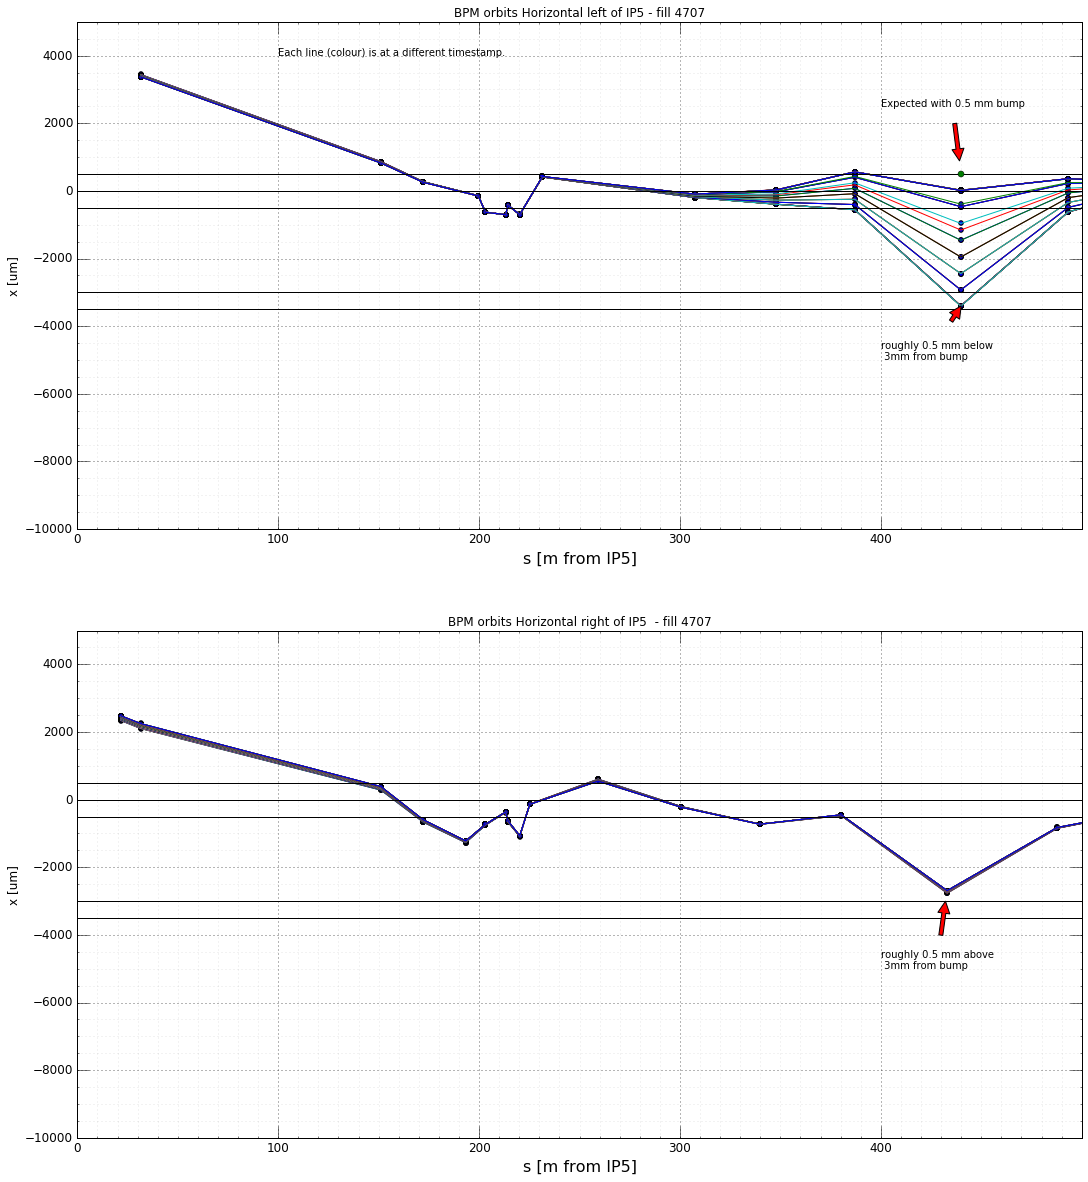

100.0


In [28]:
plotbpm(fill4707,
        '/afs/cern.ch/work/t/tomerten/HI2015/LHCTwiss-LHCB1.tfs',
        '/afs/cern.ch/work/t/tomerten/HI2015/lhcb2-twiss-noerr.tfs',
        ipnr=5,nn=1000,step=20)